In [ ]:
#get to know my data
import pandas as pd
EXCEL_PATH = "/Users/liujiaqi/Documents/ETHZurich/second_semester/master_project/Zurich_data/zurich_place_generator.xlsx"
df = pd.read_excel(EXCEL_PATH)
print(df["mode"].unique())
print(df["mode_5_TEXT"].unique())

['Public transport' 'Walking' 'Bike' 'Other, please describe'
 'Private car' nan 'Taxi or Uber']
[nan 'Roller' 'E Bike' 'Zu Fuss' 'Und hin manchmal mit dem Bus' 'zu Fuss'
 'Gesch<e4>ftsauto' 'Wohnmobil'
 'Mit Auto, meistens kombiniert mit Spaziergang' '1 Wegstrecke gehen'
 'E bike' 'Mittagessen mit Arbeitskollegen' 'Motorrad'
 'sehr unterschiedlich' 'zu Fuss, vom eigenen Schiff im Hafen' 'Vespa'
 'roller'
 'auch mit dem Velo, das ich manchmal nach Hause in den Bus 31 nehme'
 'Someone drive me there, Uber home' 'Nordic Walking' 'Pferd' 'Joggen'
 'Rennen' 'Gehen und joggen' 'Fahrrad und Gehen' 'zu fuss' 'joggend'
 'Ich gehe mit dem Hund spazieren' 'Spazieren' 'Velotouren in der Region'
 'Mein Partner wohnt in Herrliberg' 'jogging'
 'Nach Wahl mit GA ABONNEMENT' 'Gondelbahn' 'Laufsport' 'Velo' 'Oferd'
 'Lieu d<U+0092>habitation ou de promenade' 'ich gehe joggen'
 'Sommer Fahred, Winter <f6>ffentlicher Verkehr' 'Rarement'
 'Fahrrad oder privates Auto, je nach Wetter' 'Online' 'Motorroller'

In [33]:
import geopandas as gpd
SHAPE_PATH          = r"/Users/liujiaqi/Documents/ETHZurich/second_semester/master_project/shapefiles/e563b9c3-2ce3-11f0-a79d-005056b0ce82/data/stzh.adm_statistische_quartiere_map.shp"

gdf = gpd.read_file(SHAPE_PATH)
print(gdf.head())

   objectid objid   qnr        qname  knr    kname  \
0         1    34  73.0   Hirslanden  7.0  Kreis 7   
1         2    33  83.0      Weinegg  8.0  Kreis 8   
2         3    32  82.0    Mühlebach  8.0  Kreis 8   
3         4    31  81.0      Seefeld  8.0  Kreis 8   
4         5    30  21.0  Wollishofen  2.0  Kreis 2   

                                            geometry  
0  POLYGON ((2684457.034 1246514.804, 2684466.315...  
1  POLYGON ((2684457.383 1246512.719, 2684458.291...  
2  POLYGON ((2684269.913 1246566.796, 2684271.618...  
3  POLYGON ((2683794.254 1246609.895, 2683802.117...  
4  POLYGON ((2683464.971 1243316.936, 2683455.914...  


In [40]:
import pandas as pd

EXCEL_PATH = r"/Users/liujiaqi/Documents/ETHZurich/second_semester/master_project/Zurich_data/zurich_place_generator.xlsx"
df = pd.read_excel(EXCEL_PATH)

modes = df['mode'].dropna().unique()
print(modes)

counts = df['mode'].value_counts()
print(counts)

['Public transport' 'Walking' 'Bike' 'Other, please describe'
 'Private car' 'Taxi or Uber']
mode
Private car               3296
Walking                   2729
Public transport          1789
Bike                      1653
Other, please describe     146
Taxi or Uber                13
Name: count, dtype: int64


In [ ]:

def classify_mode(x):
    if pd.isna(x):
        return 'Other'
    
    x_lower = str(x).lower()
    
    # Direct mapping
    standard_map = {
        'public transport': 'Public transport',
        'walking': 'Walking',
        'bike': 'Bike',
        'private car': 'Private car',
        'taxi or uber': 'Taxi or Uber',
        'other, please describe': 'Other'
    }
    if x_lower in standard_map:
        return standard_map[x_lower]
    
    # Fallback fuzzy matching
    if any(k in x_lower for k in ['zu fuss', 'gehen', 'spazieren', 'jog', 'laufen', 'walking', 'rennen']):
        return 'Walking'
    elif any(k in x_lower for k in ['velo', 'bike', 'fahrrad', 'e-bike', 'roller', 'trotti']):
        return 'Bike'
    elif any(k in x_lower for k in ['auto', 'privat', 'pw', 'wohnmobil', 'geschä', 'fahrzeu']):
        return 'Private car'
    elif any(k in x_lower for k in ['bus', 'tram', 'vbz', 'gondel', 'eth link']):
        return 'Public transport'
    else:
        return 'Other'


# Apply classification
df['mode_class'] = df['mode_combined'].apply(classify_mode)

print(df['mode_class'].value_counts())


mode_class
Private car         3301
Walking             2773
Public transport    1794
Bike                1694
Other                286
Taxi or Uber          13
Name: count, dtype: int64


In [27]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
import networkx as nx
from tqdm import tqdm

# === File paths ===
EXCEL_PATH = "/Users/liujiaqi/Documents/ETHZurich/second_semester/master_project/Zurich_data/zurich_place_generator.xlsx"
SHAPEFILE_PATH = "/Users/liujiaqi/Documents/ETHZurich/second_semester/master_project/shapefiles/e563b9c3-2ce3-11f0-a79d-005056b0ce82/data/stzh.adm_statistische_quartiere_map.shp"
OUTPUT_PATH = "/Users/liujiaqi/Documents/ETHZurich/second_semester/master_project/Zurich_data/zurich_distances.parquet"

# === Field settings ===
ORIG_LAT, ORIG_LON = "hh_lat", "hh_lon"
DEST_LAT, DEST_LON = "lat", "lon"
MODE_COL = "mode"

# === Load data & process visits_num ===
df = pd.read_excel(EXCEL_PATH).dropna(subset=[ORIG_LAT, ORIG_LON, DEST_LAT, DEST_LON])
visits_map = {
    "Less than once a month": 0.5,
    "Once or twice every two weeks": 3,
    "Once or twice a month": 1.5,
    "Between 1 and 3 times a week": 8.0,
    "Between 4 and 7 times a week": 22.0,
    "Daily": 30.0
}
df["visits_num"] = df["visits"].map(visits_map).fillna(0)

# === Assign zone information to each destination ===
zones = gpd.read_file(SHAPEFILE_PATH).to_crs("EPSG:4326")
zone_id_col = [c for c in zones.columns if c not in ['geometry', 'qname']][0]
zones = zones.rename(columns={zone_id_col: 'zone_id', 'qname': 'zone_name'})
dest = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[DEST_LON], df[DEST_LAT]), crs="EPSG:4326")
dest = gpd.sjoin(dest, zones[['zone_id', 'zone_name', 'geometry']], how='inner', predicate='within').drop(columns=['index_right'])

# === Construct multiple transport mode graphs ===
mode_mapping = {
    'Walking': 'walk',
    'Bike': 'bike',
    'Private car': 'drive',
    'Public transport': 'drive',  # fallback
    'Taxi or Uber': 'drive',
    'Other, please describe': 'drive'
}
city_poly = zones.geometry.unary_union
transport_modes = set(dest[MODE_COL].map(mode_mapping.get).dropna())
graph_dict = {mode: ox.graph_from_polygon(city_poly, network_type=mode) for mode in transport_modes}

# === Define distance calculation function ===
def get_route_distance(row):
    net_type = mode_mapping.get(row[MODE_COL], 'drive')
    G = graph_dict.get(net_type, graph_dict['drive'])
    try:
        orig_node = ox.distance.nearest_nodes(G, row[ORIG_LON], row[ORIG_LAT])
        dest_node = ox.distance.nearest_nodes(G, row[DEST_LON], row[DEST_LAT])
        length = nx.shortest_path_length(G, orig_node, dest_node, weight='length')
        return length / 1000
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return np.nan

# === Compute distances (with progress bar) ===
from tqdm.contrib.concurrent import process_map
tqdm.pandas()
dest['dist_km'] = dest.progress_apply(get_route_distance, axis=1)

# === Save results ===
dest[['zone_id', 'zone_name', 'dist_km', 'visits_num']].to_parquet(OUTPUT_PATH, index=False)
print(f"Saved to: {OUTPUT_PATH}")


/var/folders/k_/8m0hf3h96bg_t8dfgwsfjnv00000gn/T/ipykernel_41197/1257711706.py:46: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  city_poly = zones.geometry.unary_union
100%|██████████| 2665/2665 [09:26<00:00,  4.70it/s]

Saved to: /Users/liujiaqi/Documents/ETHZurich/second_semester/master_project/Zurich_data/zurich_distances.parquet


/var/folders/k_/8m0hf3h96bg_t8dfgwsfjnv00000gn/T/ipykernel_51183/1897705475.py:24: RuntimeWarning: overflow encountered in exp
  def expo(x,a,b):    return a * np.exp(-b*x)                   # exponential decay
/var/folders/k_/8m0hf3h96bg_t8dfgwsfjnv00000gn/T/ipykernel_51183/1897705475.py:24: RuntimeWarning: overflow encountered in exp
  def expo(x,a,b):    return a * np.exp(-b*x)                   # exponential decay
/var/folders/k_/8m0hf3h96bg_t8dfgwsfjnv00000gn/T/ipykernel_51183/1897705475.py:24: RuntimeWarning: overflow encountered in exp
  def expo(x,a,b):    return a * np.exp(-b*x)                   # exponential decay
/var/folders/k_/8m0hf3h96bg_t8dfgwsfjnv00000gn/T/ipykernel_51183/1897705475.py:24: RuntimeWarning: overflow encountered in exp
  def expo(x,a,b):    return a * np.exp(-b*x)                   # exponential decay
/var/folders/k_/8m0hf3h96bg_t8dfgwsfjnv00000gn/T/ipykernel_51183/1897705475.py:24: RuntimeWarning: overflow encountered in exp
  def expo(x,a,b):    return 

✅ Saved: avg_decay_curves.png
✅ Saved: zurich_decay_custom_static.png


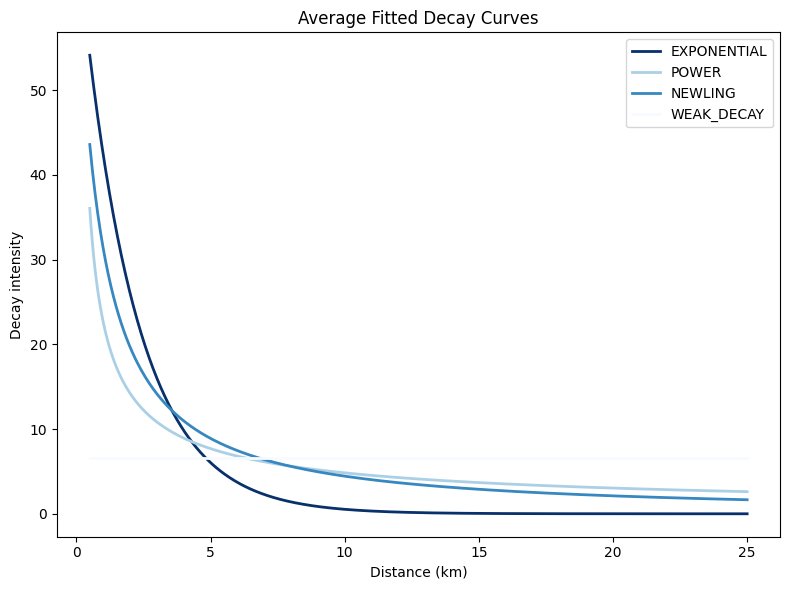

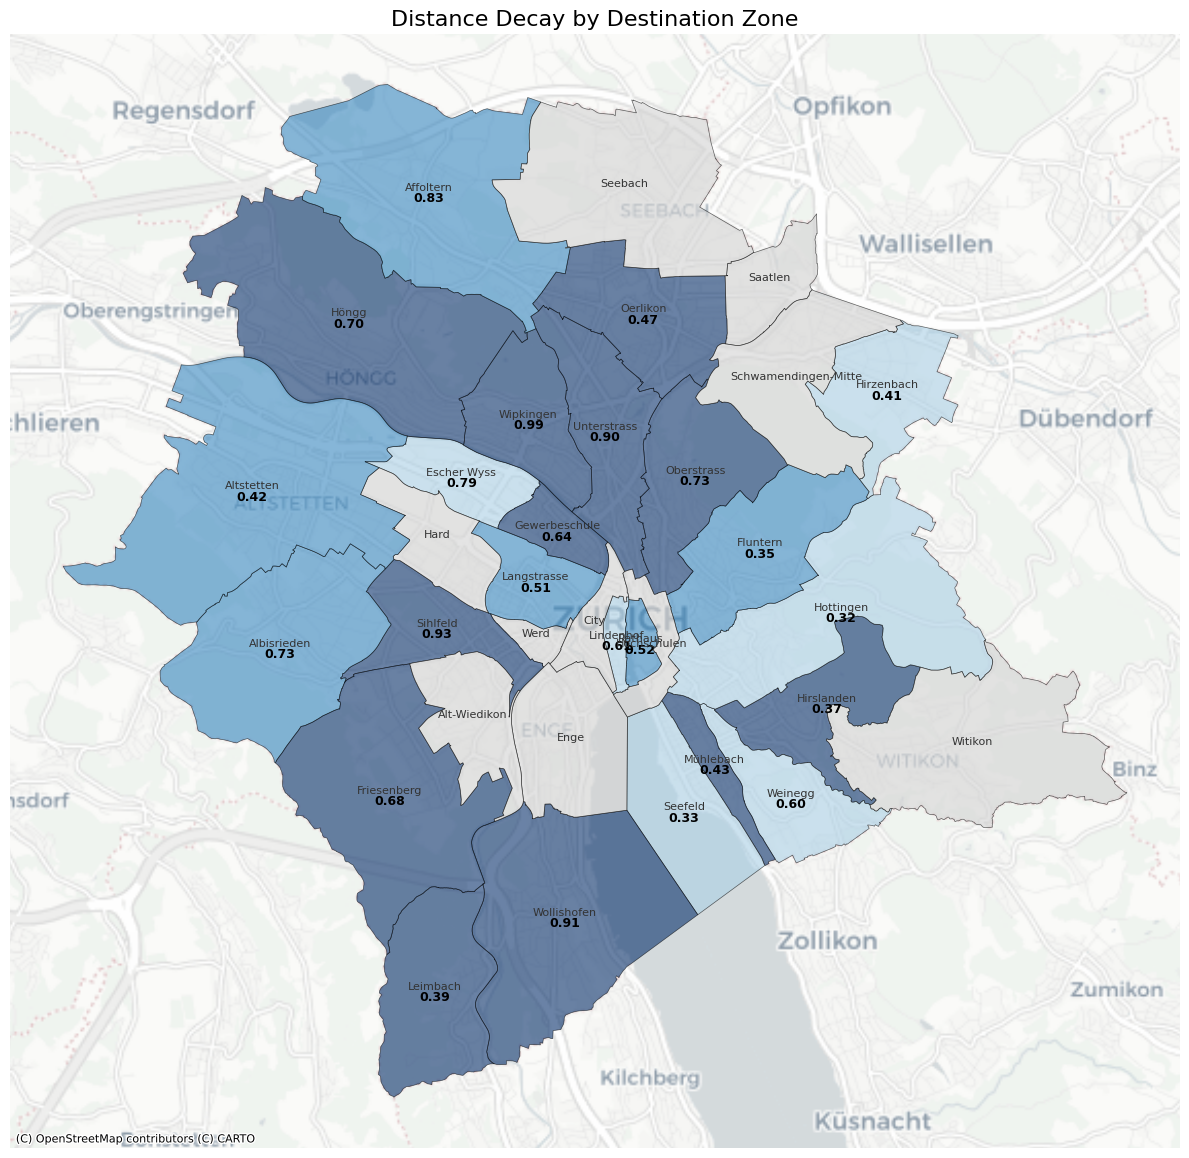

In [1]:
# === Decay fitting & visualization script with blue color mapping ===

# --- Import required libraries ---
import pandas as pd                 # for data manipulation
import numpy as np                  # for numerical operations
from scipy.optimize import curve_fit  # for fitting nonlinear functions to data
from math import log                # for logarithmic calculation (used in AIC)
import matplotlib.pyplot as plt     # for plotting
import geopandas as gpd             # for handling geographic data
import contextily as ctx            # for adding basemap tiles to plots
import matplotlib.cm as cm          # for colormap handling
from matplotlib.colors import to_hex # for converting RGBA to hex color codes

# --- File paths for input data ---
EXCEL_PATH     = "/Users/liujiaqi/Documents/ETHZurich/second_semester/master_project/Zurich_data/zurich_place_generator.xlsx"
PARQUET_PATH   = "/Users/liujiaqi/Documents/ETHZurich/second_semester/master_project/Zurich_data/zurich_distances.parquet"
SHAPEFILE_PATH = "/Users/liujiaqi/Documents/ETHZurich/second_semester/master_project/shapefiles/e563b9c3-2ce3-11f0-a79d-005056b0ce82/data/stzh.adm_statistische_quartiere_map.shp"

# --- Parameters ---
BIN_SIZE_KM = 0.5        # distance bin size for histogram
MAX_DIST_KM = 25         # maximum distance to consider for decay fitting

# --- Define decay functions ---
def expo(x,a,b):    return a * np.exp(-b*x)                   # exponential decay

def power(x,a,b):   return a * (x+1e-6)**(-b)                # power-law decay, add small constant to avoid zero

def newling(x,a,b): return a/(x+1)**b                        # Newling decay function

def weak(x,a):      return a * np.ones_like(x)              # flat decay (no decay)

# Dictionary to store functions and their number of parameters
FUNC_DICT = {
    'EXPONENTIAL': (expo, 2),
    'POWER':       (power, 2),
    'NEWLING':     (newling, 2),
    'WEAK_DECAY':  (weak, 1),
}

# Function to compute Akaike Information Criterion (AIC)
def aic(n, rss, k):
    return np.inf if rss <= 0 else n * log(rss / n) + 2 * k  # rss: residual sum of squares; k: number of parameters

# === 1) Load and prepare distance data ===
df = pd.read_parquet(PARQUET_PATH)        # load trip distance data (already preprocessed)
df.columns = df.columns.str.strip()       # remove any extra spaces in column names
df = pd.DataFrame(df)                     # ensure it is a DataFrame

# === 2) Fit decay functions for each zone ===
results = []
for zid, grp in df.groupby('zone_id'):   # loop through each zone
    data = grp['dist_km'].clip(0, MAX_DIST_KM)          # clip distances at max limit
    weights = grp['visits_num'].clip(lower=0)           # use number of visits as weight (ignore negative)
    if weights.sum() == 0:
        print(f"zone_id {zid} has zero total visits weight, skipped.")
        continue

    # Bin distances and sum weights
    bins = np.arange(0, MAX_DIST_KM + BIN_SIZE_KM, BIN_SIZE_KM)
    f, e = np.histogram(data, bins=bins, weights=weights)  # frequency (weighted)
    x = (e[:-1] + e[1:]) / 2     # compute bin centers
    y = f                       # counts per bin
    mask = y > 0                # filter out empty bins
    x, y = x[mask], y[mask]
    if len(x) < 2:
        continue

    best = {'aic': np.inf}                          # store best model info
    ss_tot = ((y - y.mean()) ** 2).sum()            # total sum of squares for R^2

    # Try fitting each decay function
    for name, (func, k) in FUNC_DICT.items():
        if len(x) <= k:                             # skip if not enough data points
            continue
        try:
            popt, _ = curve_fit(func, x, y, maxfev=5000)     # fit function
            y_pred = func(x, *popt)                           # predicted values
            rss = ((y - y_pred) ** 2).sum()                   # residual sum of squares
            r2 = 1 - rss / ss_tot if ss_tot > 0 else np.nan  # R-squared
            current_aic = aic(len(y), rss, k)                 # compute AIC
            if current_aic < best['aic']:                     # update best if lower AIC found
                best.update(type=name, aic=current_aic, r2=r2, params=popt)
        except:
            continue

    if 'type' in best:
        results.append({
            'zone_id': zid,
            'decay_type': best['type'],
            'r2': best['r2'],
            'params': best['params']
        })

res_df = pd.DataFrame(results)   # create DataFrame from fitting results

# === 3) Assign color to each decay type using blue gradient ===
ordered_decay = [ 'WEAK_DECAY',  'POWER', 'NEWLING','EXPONENTIAL']
decays_in_data = [d for d in ordered_decay if d in res_df['decay_type'].unique()]  # keep only those present in data

blue_cmap = cm.get_cmap('Blues', len(decays_in_data))           # use matplotlib Blues colormap
COLOR_MAP = {
    decay: to_hex(blue_cmap(i / len(decays_in_data)))           # convert colormap to hex for each decay
    for i, decay in enumerate(decays_in_data)
}

# === 4) Plot average decay curve for each type ===
x_plot = np.linspace(0.5, MAX_DIST_KM, 500)          # x values for smooth plotting
plt.figure(figsize=(8,6))
for name, (func, _) in FUNC_DICT.items():
    pops = res_df.loc[res_df['decay_type'] == name, 'params'].tolist()  # collect params of that type
    if not pops: continue
    avg_params = np.mean(np.vstack(pops), axis=0)   # compute average parameters
    plt.plot(x_plot, func(x_plot, *avg_params), label=name, color=COLOR_MAP.get(name, 'gray'), linewidth=2)
plt.xlabel("Distance (km)")
plt.ylabel("Decay intensity")
plt.legend()
plt.title("Average Fitted Decay Curves")
plt.tight_layout()
plt.savefig("avg_decay_curves.png", dpi=300)
print("✅ Saved: avg_decay_curves.png")

# === 5) Visualize decay type per zone on Zurich map ===
zones = gpd.read_file(SHAPEFILE_PATH).to_crs(epsg=4326)              # load shapefile and convert CRS to lat/lon
orig_id = [c for c in zones.columns if c not in ['geometry', 'qname']][0]  # find original zone_id column
zones = zones.rename(columns={orig_id: 'zone_id', 'qname': 'zone_name'})  # rename columns
zones = zones.merge(res_df, on='zone_id', how='left')              # merge with decay fitting result
zones_m = zones.to_crs(epsg=3857)                                  # convert to web map projection for basemap

# Assign color only if model fit is decent (R^2 >= 0.3)
zones_m['color'] = zones_m.apply(
    lambda row: COLOR_MAP.get(row['decay_type']) if pd.notna(row['r2']) and row['r2'] >= 0.3 else 'lightgray',
    axis=1
)

# Plot the static map
fig, ax = plt.subplots(figsize=(12, 12))
zones_m.plot(
    ax=ax,
    color=zones_m['color'],
    edgecolor='black',
    linewidth=0.5,
    alpha=0.6
)
ctx.add_basemap(ax, source=ctx.providers['CartoDB']['Positron'])  # add basemap tiles

# Add zone names and R^2 values to map
for _, row in zones_m.iterrows():
    if row['geometry'].is_empty:
        continue
    cent = row.geometry.centroid
    ax.text(
        cent.x, cent.y + 100,                # display zone name above
        row['zone_name'],
        ha='center', va='center',
        fontsize=8, color='#333'
    )
    if pd.notna(row['r2']) and row['r2'] >= 0.3:
        ax.text(
            cent.x, cent.y - 100,            # display R^2 value below
            f"{row['r2']:.2f}",
            ha='center', va='center',
            fontsize=9, fontweight='bold'
        )

ax.set_axis_off()
plt.title("Distance Decay by Destination Zone", fontsize=16)
plt.tight_layout()
plt.savefig("zurich_decay_custom_static.png", dpi=300)
print("✅ Saved: zurich_decay_custom_static.png")


In [14]:
print("✅ df.columns:")
print(list(df.columns))


✅ df.columns:
['zone_id', 'zone_name', 'dist_km', 'visits_num']


In [13]:
import pandas as pd
df = pd.read_parquet("zurich_distances.parquet")
print(df.columns)
print(df['visits_num'].head())



Index(['zone_id', 'zone_name', 'dist_km', 'visits_num'], dtype='object')
0     2.0
1    20.0
2     2.0
3     0.5
4     0.5
Name: visits_num, dtype: float64


In [1]:
"""
Selecting K New Restaurant Locations – Fuzzy Coverage (with Elastic Radius)
"""

# === Import libraries ===
import osmnx as ox, networkx as nx, pandas as pd, geopandas as gpd
from shapely.geometry import Point                              # For creating coordinate points
from ortools.linear_solver import pywraplp                     # For MILP optimization
from tqdm import tqdm                                           # For progress bar in loops
import folium, contextily as ctx, numpy as np                  # For mapping and numerical ops

# === Parameters ===
CITY                = "Zurich, Switzerland"                    # Study area
EXCEL_PATH          = r"/Users/liujiaqi/Documents/ETHZurich/second_semester/python/project/zurich_route_distance.xlsx"
POP_LAT, POP_LON    = "ego_lat", "ego_lon"                     # Column names for resident coordinates
POP_RADIUS_KM       = "ego_place_route_km"                    # Travel radius (individual threshold r_i)
POP_WEIGHT          = POP_RADIUS_KM                            # Weights assigned as travel radii (can reflect importance)
GRID_SPACING_M      = 100                                      # Grid spacing for candidate locations (in meters)
K_NEW_RESTAURANTS   = 3                                        # Number of new locations to be selected
DELTA_KM            = 0.50                                     # Elasticity margin: how far coverage can extend beyond r_i
MU_EPS              = 1e-6                                     # Small epsilon to avoid division-by-zero or float errors

# === Step 1: Load resident data ===
print("1) Reading resident data …")
pop_df = pd.read_excel(EXCEL_PATH).dropna(subset=[POP_LAT, POP_LON, POP_RADIUS_KM])
pop_gdf = gpd.GeoDataFrame(
    pop_df,
    geometry=gpd.points_from_xy(pop_df[POP_LON], pop_df[POP_LAT]),
    crs="EPSG:4326"
)

# === Step 2: Load existing restaurants for visualization ===
print("2) Fetching existing restaurants from OSM (for map visualization)")
restaurants = ox.geometries_from_place(
    CITY, tags={"amenity": "restaurant"}
) if hasattr(ox, "geometries_from_place") else ox.features_from_place(
    CITY, tags={"amenity": "restaurant"}
)
restaurants = restaurants.to_crs("EPSG:4326")
restaurants = restaurants[restaurants.geometry.type == "Point"]   # Keep only point geometries

# === Step 3: Generate candidate locations on a grid ===
print("3) Generating candidate points …")
city_poly = ox.geocode_to_gdf(CITY).geometry.iloc[0].buffer(0.001)   # Get city boundary and buffer to avoid edge clipping
xmin, ymin, xmax, ymax = city_poly.bounds                            # Get city bounds
xs = np.arange(xmin, xmax, GRID_SPACING_M / 111_000)                 # Grid x-coordinates (approx 111km per degree)
ys = np.arange(ymin, ymax, GRID_SPACING_M / 111_000)                 # Grid y-coordinates
# Create grid points only within city polygon
grid_points = [Point(x, y) for x in xs for y in ys if city_poly.contains(Point(x, y))]
cand_gdf = gpd.GeoDataFrame(geometry=grid_points, crs="EPSG:4326")
print(f"   Number of candidate locations: {len(cand_gdf)}")

# === Haversine distance calculation function (in km) ===
def haversine(a, b):
    lat1, lon1, lat2, lon2 = map(np.radians, (*a, *b))
    dlat, dlon = lat2 - lat1, lon2 - lon1
    c = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    return 6371 * 2 * np.arctan2(np.sqrt(c), np.sqrt(1 - c))

# === Step 4: Precompute distances and fuzzy coverage coefficients ===
pop_coords  = pop_gdf.geometry.apply(lambda p: (p.y, p.x)).tolist()    # (lat, lon) for each resident
cand_coords = cand_gdf.geometry.apply(lambda p: (p.y, p.x)).tolist()   # (lat, lon) for each candidate
I, J        = len(pop_coords), len(cand_coords)                        # I = num of residents, J = candidates
W           = pop_gdf[POP_WEIGHT].values                               # Weights per individual (importance)

print("4) Precomputing distances & fuzzy coverage coefficients f_ij …")
reach_list, fcoef_list = [], []  # To store which j's are reachable for each i and how much (coverage coeffs)
for i, (lat_i, lon_i) in tqdm(list(enumerate(pop_coords))):
    r_i   = pop_gdf.iloc[i][POP_RADIUS_KM]              # Personal radius r_i
    row_j, row_f = [], []
    for j, (lat_j, lon_j) in enumerate(cand_coords):
        d = haversine((lat_i, lon_i), (lat_j, lon_j))
        if d <= r_i + DELTA_KM + MU_EPS:                # Only consider locations within elastic radius
            if d <= r_i + MU_EPS:
                f_ij = 1.0                               # Full coverage if within base radius
            else:
                f_ij = (r_i + DELTA_KM - d) / DELTA_KM   # Linearly decay to 0
            row_j.append(j)
            row_f.append(max(0.0, min(1.0, f_ij)))       # Clamp to [0,1] for safety
    reach_list.append(row_j)
    fcoef_list.append(row_f)

# === Step 5: MILP model using ortools ===
print("5) Building MILP (Fuzzy-MCLP) …")
solver = pywraplp.Solver.CreateSolver("SCIP")
x  = [solver.BoolVar(f"x{j}") for j in range(J)]             # Binary var: whether to select location j
mu = [[None]*len(reach_list[i]) for i in range(I)]           # Coverage degree variable μ_ij
z  = [solver.NumVar(0, 1, f"z{i}") for i in range(I)]        # Overall coverage level per individual i

# 5.1 Constraints: μ_ij ≤ f_ij · x_j
for i in range(I):
    for idx, j in enumerate(reach_list[i]):
        mu[i][idx] = solver.NumVar(0, 1, f"mu{i}_{j}")       # Define μ_ij variable
        f_ij = fcoef_list[i][idx]
        solver.Add(mu[i][idx] <= f_ij * x[j])                # Only covered if j is selected

# 5.2 Constraint: exactly K restaurants are selected
solver.Add(solver.Sum(x) == K_NEW_RESTAURANTS)

# 5.3 Constraints: z_i ≤ ∑ μ_ij and ≤ 1
for i in range(I):
    solver.Add(z[i] <= 1)                                   # Max coverage is 1
    solver.Add(z[i] <= solver.Sum(mu[i]))                   # z_i limited by reachable coverage

# 5.4 Objective: maximize total weighted coverage
solver.Maximize(solver.Sum(W[i] * z[i] for i in range(I)))

# === Solve the MILP ===
print("   Solving …")
status = solver.Solve()
if status != solver.OPTIMAL:
    raise RuntimeError("No optimal solution found")

# === Extract selected restaurant coordinates ===
chosen = [j for j in range(J) if x[j].solution_value() > 0.5]   # Indices of selected points
print(f"Recommended new restaurant locations (total {len(chosen)}):")
for idx, j in enumerate(chosen, 1):
    lat, lon = cand_coords[j]
    print(f"{idx}. ({lat:.6f}, {lon:.6f})")

# === Step 6: Interactive map visualization ===
m = folium.Map(location=[47.3769, 8.5417], zoom_start=12, tiles="cartodbpositron")
# Show Zurich boundary
city_poly_json = folium.GeoJson(city_poly.__geo_interface__, name="City border",
        style_function=lambda x: {"fill": False, "color": "#555", "weight": 3})
city_poly_json.add_to(m)

# Overlay urban area polygons
urban = ox.features_from_place(CITY, tags={"landuse": "residential"}).to_crs("EPSG:4326")
urban = urban[urban.geometry.type.isin(["Polygon", "MultiPolygon"])]
folium.GeoJson(urban.unary_union.__geo_interface__, name="Urban area",
        style_function=lambda x: {"fillColor": "#2c7fb8", "fillOpacity": .25,
                                  "color": "#2c7fb8", "weight": 1}).add_to(m)

# Mark existing restaurants
for p in restaurants.geometry.apply(lambda g: (g.y, g.x)).tolist():
    folium.CircleMarker(location=p, radius=2, color="gray", fill=True).add_to(m)

# Mark new restaurant locations
for k, j in enumerate(chosen, 1):
    p = cand_coords[j]
    folium.Marker(location=p, popup=f"New {k}",
                  icon=folium.Icon(color="red")).add_to(m)

# Save map
m.save("zurich_new_restaurants_fuzzy.html")
m


1) Reading resident data …
2) Fetching existing restaurants from OSM (for map visualization)
3) Generating candidate points …
   Number of candidate locations: 14282
4) Precomputing distances & fuzzy coverage coefficients f_ij …


100%|██████████| 1081/1081 [01:50<00:00,  9.76it/s]


5) Building MILP (Fuzzy-MCLP) …
   Solving …
Recommended new restaurant locations (total 3):
1. (47.384985, 8.501961)
2. (47.322822, 8.518178)
3. (47.406606, 8.585745)


/var/folders/k_/8m0hf3h96bg_t8dfgwsfjnv00000gn/T/ipykernel_4085/3962590532.py:131: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  folium.GeoJson(urban.unary_union.__geo_interface__, name="Urban area",
